# Hedonic Pricing

We often try to predict the price of an asset from its observable characteristics. This is generally called **hedonic pricing**: How do the unit's characteristics determine its market price?

In the lab folder, there are three options: housing prices in pierce_county_house_sales.csv, car prices in cars_hw.csv, and airbnb rental prices in airbnb_hw.csv. If you know of another suitable dataset, please feel free to use that one.

1. Clean the data and perform some EDA and visualization to get to know the data set.
2. Transform your variables --- particularly categorical ones --- for use in your regression analysis.
3. Implement an ~80/~20 train-test split. Put the test data aside.
4. Build some simple linear models that include no transformations or interactions. Fit them, and determine their RMSE and $R^2$ on the both the training and test sets. Which of your models does the best?
5. Make partial correlation plots for each of the numeric variables in your model. Do you notice any significant non-linearities? 
6. Include transformations and interactions of your variables, and build a more complex model that reflects your ideas about how the features of the asset determine its value. Determine its RMSE and $R^2$ on the training and test sets. How does the more complex model your build compare to the simpler ones?
7. Summarize your results from 1 to 6. Have you learned anything about overfitting and underfitting, or model selection?
8. If you have time, use the sklearn.linear_model.Lasso to regularize your model and select the most predictive features. Which does it select? What are the RMSE and $R^2$? We'll cover the Lasso later in detail in class.

In [47]:
# PART 1
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# load and show df
df = pd.read_csv('data/cars_hw.csv')
df

,Unnamed: 0,Make,Make_Year,Color,Body_Type,Mileage_Run,No_of_Owners,Seating_Capacity,Fuel_Type,Transmission,Transmission_Type,Price
0,1,Volkswagen,2017,silver,sedan,44611,1st,5,diesel,7-Speed,Automatic,657000
1,2,Hyundai,2016,red,crossover,20305,1st,5,petrol,5-Speed,Manual,682000
2,3,Honda,2019,white,suv,29540,2nd,5,petrol,5-Speed,Manual,793000
3,4,Renault,2017,bronze,hatchback,35680,1st,5,petrol,5-Speed,Manual,414000
4,5,Hyundai,2017,orange,hatchback,25126,1st,5,petrol,5-Speed,Manual,515000
...,...,...,...,...,...,...,...,...,...,...,...,...
971,972,Hyundai,2018,white,sedan,23869,1st,5,petrol,6-Speed,Automatic,956000
972,973,Hyundai,2019,white,sedan,14831,1st,5,petrol,6-Speed,Automatic,1027000
973,974,Hyundai,2014,silver,sedan,52846,1st,5,petrol,4-Speed,Automatic,736000
974,975,Ford,2020,white,crossover,28335,2nd,5,diesel,5-Speed,Automatic,749000


In [48]:
# changing number of owners to a number
df['No_of_Owners'] = df['No_of_Owners'].str.replace('st', '')
df['No_of_Owners'] = df['No_of_Owners'].str.replace('nd', '')
df['No_of_Owners'] = df['No_of_Owners'].str.replace('rd', '')
df['No_of_Owners'] = df['No_of_Owners'].str.replace('th', '')
df['No_of_Owners'] = df['No_of_Owners'].astype(int)

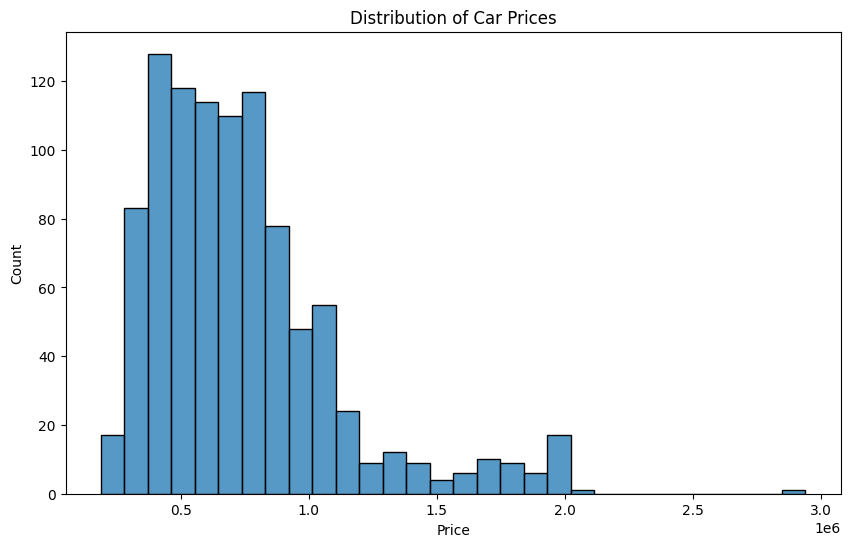

In [49]:
# histogram distribution of prices
plt.figure(figsize=(10, 6))
sns.histplot(df['Price'], bins=30)
plt.title('Distribution of Car Prices')
plt.xlabel('Price')
plt.show()

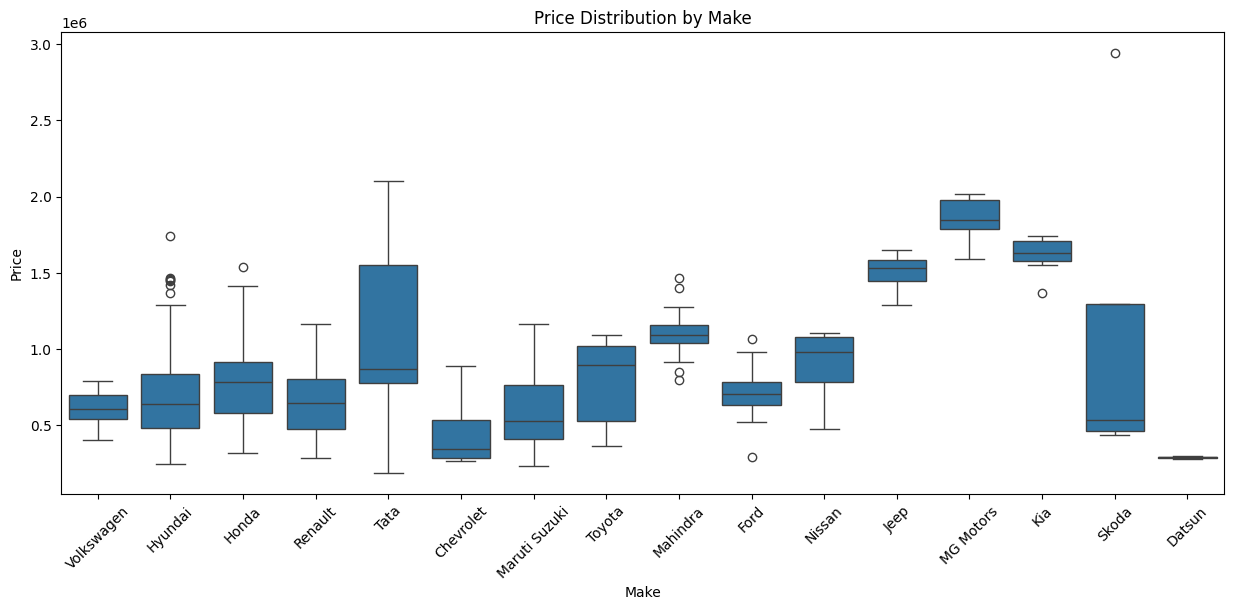

In [50]:
# box plot of prices, grouped by their make
plt.figure(figsize=(15, 6))
sns.boxplot(x='Make', y='Price', data=df)
plt.xticks(rotation=45)
plt.title('Price Distribution by Make')
plt.show()

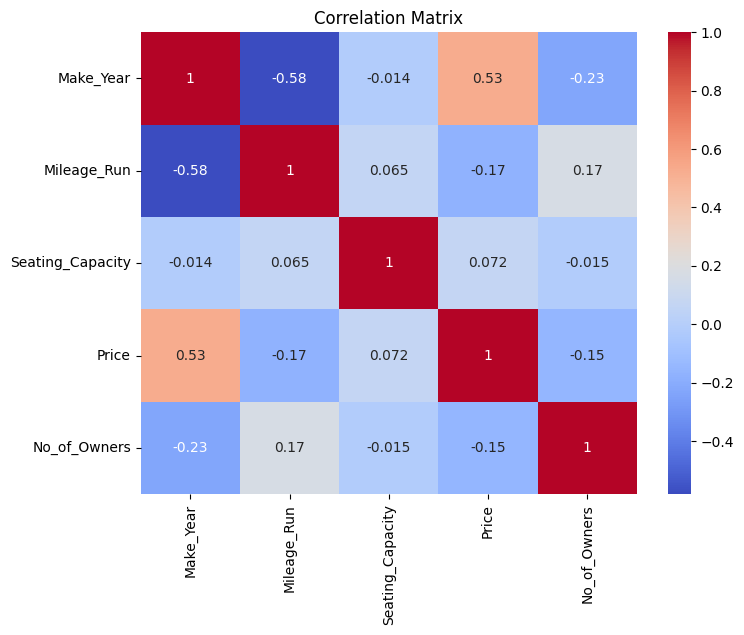

In [51]:
# heatmap of all numeric columns
numeric_cols = ['Make_Year', 'Mileage_Run', 'Seating_Capacity', 'Price', 'No_of_Owners']
plt.figure(figsize=(8, 6))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [52]:
# PART 2
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# handle categorical variables using dummy variables
categorical_cols = ['Make', 'Color', 'Body_Type', 'Fuel_Type', 'Transmission', 'Transmission_Type']
X_categorical = pd.get_dummies(df[categorical_cols], drop_first=True)

# scale numeric variables
numeric_cols = ['Make_Year', 'Mileage_Run', 'No_of_Owners', 'Seating_Capacity']
scaler = StandardScaler()
X_numeric = pd.DataFrame(
    scaler.fit_transform(df[numeric_cols]),
    columns=numeric_cols
)

# combine transformed features
X = pd.concat([X_numeric, X_categorical], axis=1)
y = df['Price']

# print transformed dataset info
print("Transformed dataset shape:", X.shape)
print("\nNumeric features (standardized):")
print(X[numeric_cols].describe())

print("\nSample of dummy variables (first 5 columns):")
print(X.iloc[:, len(numeric_cols):len(numeric_cols)+5].head())

# Save variable names for later use in coefficient interpretation
feature_names = X.columns.tolist()

print("\nTotal number of features after transformation:", len(feature_names))
print("\nTypes of features:")
print("Numeric (standardized):", numeric_cols)
print("Categorical (dummy vars):", [col for col in feature_names if col not in numeric_cols])

Transformed dataset shape: (976, 44)

Numeric features (standardized):
          Make_Year   Mileage_Run  No_of_Owners  Seating_Capacity
count  9.760000e+02  9.760000e+02  9.760000e+02      9.760000e+02
mean   6.624937e-15 -7.280151e-18  2.111244e-16      9.955606e-16
std    1.000513e+00  1.000513e+00  1.000513e+00      1.000513e+00
min   -2.116608e+00 -1.659421e+00 -4.334651e-01     -2.455824e+00
25%   -6.968078e-01 -7.750456e-01 -4.334651e-01     -2.136498e-01
50%    1.309242e-02 -1.641076e-01 -4.334651e-01     -2.136498e-01
75%    7.229927e-01  6.501654e-01 -4.334651e-01     -2.136498e-01
max    1.787843e+00  2.376020e+00  4.789522e+00      6.512872e+00

Sample of dummy variables (first 5 columns):
   Make_Datsun  Make_Ford  Make_Honda  Make_Hyundai  Make_Jeep
0        False      False       False         False      False
1        False      False       False          True      False
2        False      False        True         False      False
3        False      False       False

In [53]:
# PART 3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Model Comparison:

1. Numeric Variables Only:
Training RMSE: 308974.06
Training R²: 0.3161
Test RMSE: 284940.59
Test R²: 0.2921

2. Categorical Variables Only:
Training RMSE: 180883.85
Training R²: 0.7656
Test RMSE: 182974.74
Test R²: 0.7081

3. All Variables:
Training RMSE: 142154.19
Training R²: 0.8552
Test RMSE: 143815.30
Test R²: 0.8197


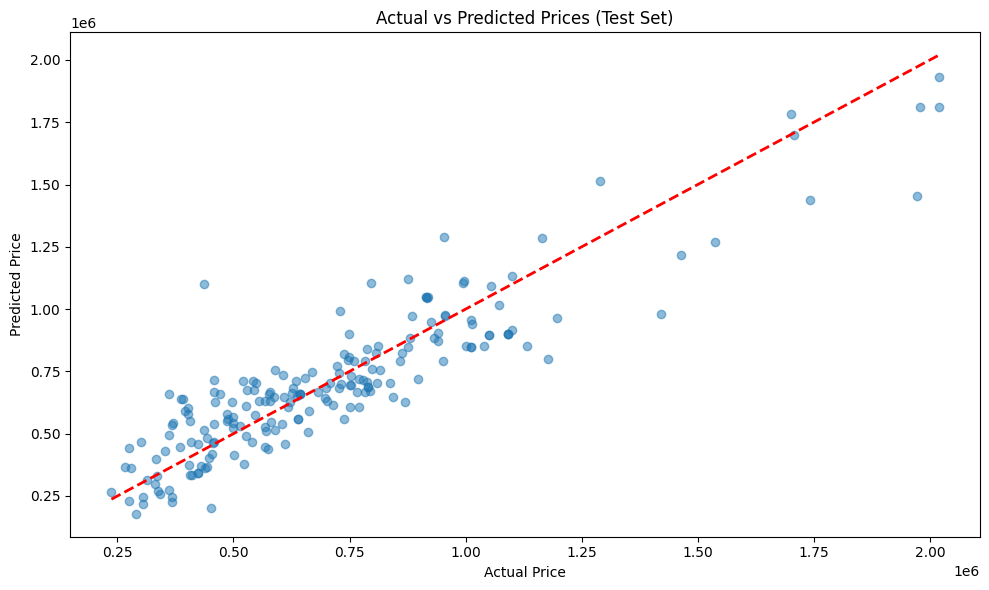

In [54]:
# PART 4
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# model for numeric variables
numeric_model = LinearRegression()
numeric_model.fit(X_train[numeric_cols], y_train)

# model for categorical variables
categorical_cols = [col for col in X_train.columns if col not in numeric_cols]
categorical_model = LinearRegression()
categorical_model.fit(X_train[categorical_cols], y_train)

# model for all variables
full_model = LinearRegression()
full_model.fit(X_train, y_train)

# function to retrieve relevant data
def get_metrics(model, X_tr, X_te, y_tr, y_te):
    # training
    y_train_pred = model.predict(X_tr)
    train_rmse = np.sqrt(mean_squared_error(y_tr, y_train_pred))
    train_r2 = r2_score(y_tr, y_train_pred)
    
    # test
    y_test_pred = model.predict(X_te)
    test_rmse = np.sqrt(mean_squared_error(y_te, y_test_pred))
    test_r2 = r2_score(y_te, y_test_pred)
    
    return train_rmse, train_r2, test_rmse, test_r2

# call upon function for each model
numeric_metrics = get_metrics(
    numeric_model, 
    X_train[numeric_cols], 
    X_test[numeric_cols], 
    y_train, 
    y_test
)
categorical_metrics = get_metrics(
    categorical_model,
    X_train[categorical_cols],
    X_test[categorical_cols],
    y_train,
    y_test
)
full_metrics = get_metrics(
    full_model,
    X_train,
    X_test,
    y_train,
    y_test
)

# print results
print("Model Comparison:")
print("\n1. Numeric Variables Only:")
print(f"Training RMSE: {numeric_metrics[0]:.2f}")
print(f"Training R²: {numeric_metrics[1]:.4f}")
print(f"Test RMSE: {numeric_metrics[2]:.2f}")
print(f"Test R²: {numeric_metrics[3]:.4f}")

print("\n2. Categorical Variables Only:")
print(f"Training RMSE: {categorical_metrics[0]:.2f}")
print(f"Training R²: {categorical_metrics[1]:.4f}")
print(f"Test RMSE: {categorical_metrics[2]:.2f}")
print(f"Test R²: {categorical_metrics[3]:.4f}")

print("\n3. All Variables:")
print(f"Training RMSE: {full_metrics[0]:.2f}")
print(f"Training R²: {full_metrics[1]:.4f}")
print(f"Test RMSE: {full_metrics[2]:.2f}")
print(f"Test R²: {full_metrics[3]:.4f}")

# visualize actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, full_model.predict(X_test), alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Prices (Test Set)')
plt.tight_layout()
plt.show()

> Based on the findings above. It seems that our model that contains all variables is best suited for prediction. Both the training and test $R^2$ values are highest, and their respective RMSE values are also the lowest. This gives us confidence that this model is ideal given all three options.

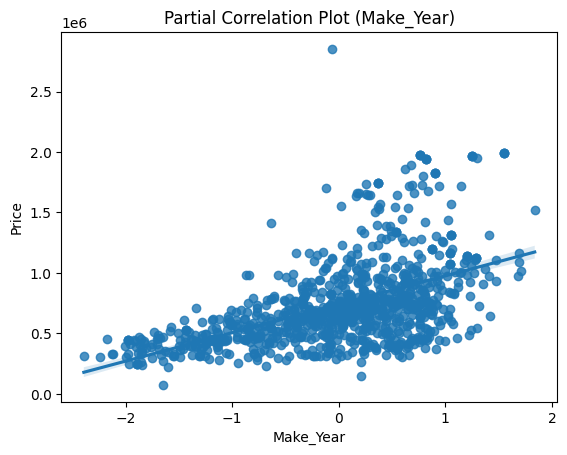

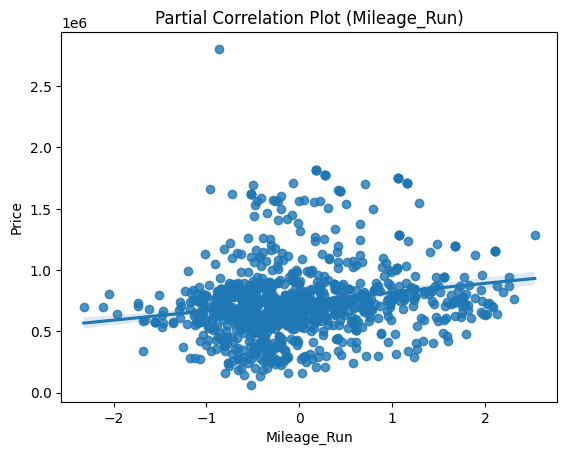

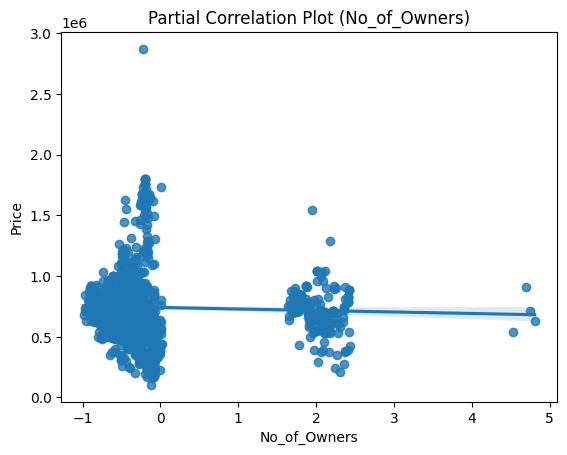

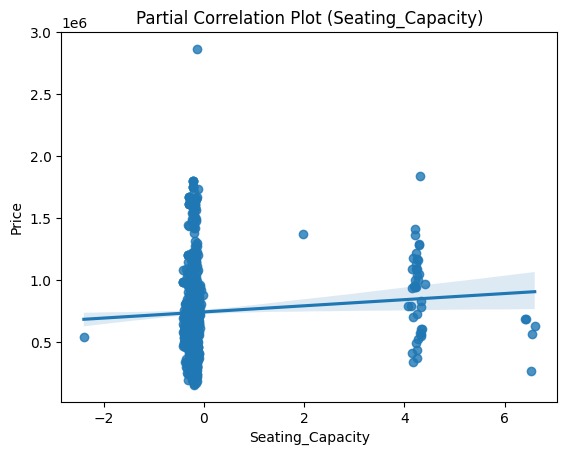

In [55]:
# PART 5

# function to plot partial correlation
def partial_corr_plot(X, y, var_name):
    # prepare data
    X_mk = X.drop(var_name, axis=1)
    x_k = X[var_name]

    # regress y on x\k, save residual r_y
    reg_y = LinearRegression(fit_intercept=False).fit(X_mk, y) # Fit the linear model
    r_y = y - reg_y.predict(X_mk)

    # regress x_k on x\k, save residual r_x
    reg_k = LinearRegression(fit_intercept=False).fit(X_mk, x_k) # Fit the linear model
    r_x = x_k - reg_k.predict(X_mk)
    
    # plot correlation
    sns.regplot(y=r_y, x=r_x)
    plt.title(f'Partial Correlation Plot ({var_name})')
    plt.show()

# create plots for each numerical column
X_numeric = X[numeric_cols].copy()
for var in numeric_cols:
    partial_corr_plot(X_numeric, y, var)

> The big non-linearities here are about the Seating_Capacity and No_of_Owners variables. These columns are more categorical in nature, simply because there's only a given amount of options these data may have. For year and mileage, there's is more variability here, so we're more prone to having linear findings.

Complex Model Performance:
Training RMSE: 139584.20
Training R²: 0.8604
Test RMSE: 143025.91
Test R²: 0.8216

Model Comparison:
Simple Model:
Training RMSE: 142154.19
Training R²: 0.8552
Test RMSE: 143815.30
Test R²: 0.8197


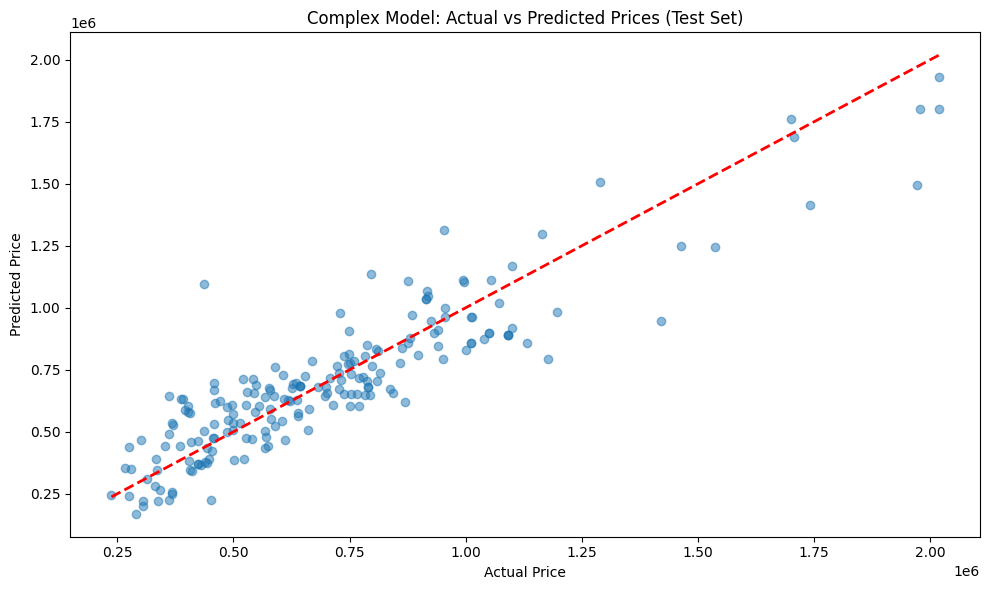


Top 10 Most Important Features (by absolute coefficient value):
                 Feature    Coefficient        AbsCoef
21        Make_MG Motors  822502.885418  822502.885418
26            Make_Skoda  677001.965436  677001.965436
20              Make_Kia  591135.014743  591135.014743
19             Make_Jeep  568306.472601  568306.472601
52  Transmission_7-Speed  295164.121253  295164.121253
27             Make_Tata  278554.309228  278554.309228
45         Body_Type_muv -244270.345233  244270.345233
35           Color_green  229474.330739  229474.330739
49  Fuel_Type_petrol+cng -225950.989612  225950.989612
28           Make_Toyota  215106.296205  215106.296205


In [56]:
# PART 6
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# create polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_numeric_poly = pd.DataFrame(
    poly.fit_transform(X[numeric_cols]),
    columns=poly.get_feature_names_out(numeric_cols)
)
X_numeric_poly['Make_Year_x_Mileage'] = X['Make_Year'] * X['Mileage_Run']

# combine with categorical variables
X_complex = pd.concat([
    X_numeric_poly,
    X[[col for col in X.columns if col not in numeric_cols]]
], axis=1)

# split data
X_train_complex, X_test_complex, y_train_complex, y_test_complex = train_test_split(
    X_complex, y, test_size=0.2, random_state=42
)

# fit model
complex_model = LinearRegression()
complex_model.fit(X_train_complex, y_train_complex)

# Calculate metrics for complex model
y_train_pred_complex = complex_model.predict(X_train_complex)
y_test_pred_complex = complex_model.predict(X_test_complex)

train_rmse_complex = np.sqrt(mean_squared_error(y_train_complex, y_train_pred_complex))
test_rmse_complex = np.sqrt(mean_squared_error(y_test_complex, y_test_pred_complex))
train_r2_complex = r2_score(y_train_complex, y_train_pred_complex)
test_r2_complex = r2_score(y_test_complex, y_test_pred_complex)

# print results
print("Complex Model Performance:")
print(f"Training RMSE: {train_rmse_complex:.2f}")
print(f"Training R²: {train_r2_complex:.4f}")
print(f"Test RMSE: {test_rmse_complex:.2f}")
print(f"Test R²: {test_r2_complex:.4f}")

# compare with previous model
print("\nModel Comparison:")
print("Simple Model:")
print(f"Training RMSE: {full_metrics[0]:.2f}")
print(f"Training R²: {full_metrics[1]:.4f}")
print(f"Test RMSE: {full_metrics[2]:.2f}")
print(f"Test R²: {full_metrics[3]:.4f}")

# visualize actual vs predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test_complex, y_test_pred_complex, alpha=0.5)
plt.plot([y_test_complex.min(), y_test_complex.max()], 
         [y_test_complex.min(), y_test_complex.max()], 
         'r--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Complex Model: Actual vs Predicted Prices (Test Set)')
plt.tight_layout()
plt.show()

# print important features
feature_importance = pd.DataFrame({
    'Feature': X_complex.columns,
    'Coefficient': complex_model.coef_
})
print("\nTop 10 Most Important Features (by absolute coefficient value):")
print(feature_importance.assign(
    AbsCoef=feature_importance['Coefficient'].abs()
).sort_values('AbsCoef', ascending=False).head(10))

> Based on the findings of this model in comparison to what we had before. The RMSE and $R^2$ is not much different. However, it is important to note that this is slightly better. This information continues to show the strength of the simple model.

> Overall, our models that focused soley on numeric or categorial data had an underfitting nature. Our combined model minimized the risk of underfitting significanlty. Along with this, the training and test data had very similar $R^2$ and RMSE values, meaning there is minimal overfitting present with the model. Of course, it won't always be a perfect model, but we still lowered the risk of running into complications with over/underfitting.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.206e+11, tolerance: 1.089e+10
  model = cd_fast.enet_coordinate_descent(



Selected Features:
                          Feature    Coefficient
21                 Make_MG Motors  153451.877296
3                Seating_Capacity  149525.212282
0                       Make_Year  125679.136493
13             Seating_Capacity^2  -98049.791015
47                  Body_Type_suv   69361.904889
18                   Make_Hyundai   64648.093568
42                    Color_white   61801.402995
44            Body_Type_hatchback  -59719.053819
40                      Color_red   58008.520401
31                     Color_blue   56875.828851
48               Fuel_Type_petrol  -54445.328261
20                       Make_Kia   52044.635808
36                     Color_grey   52005.020256
51           Transmission_6-Speed   45381.900048
26                     Make_Skoda   45050.606175
45                  Body_Type_muv  -44836.512173
41                   Color_silver   44205.305884
23             Make_Maruti Suzuki   42600.510452
33                    Color_brown   42345.597404


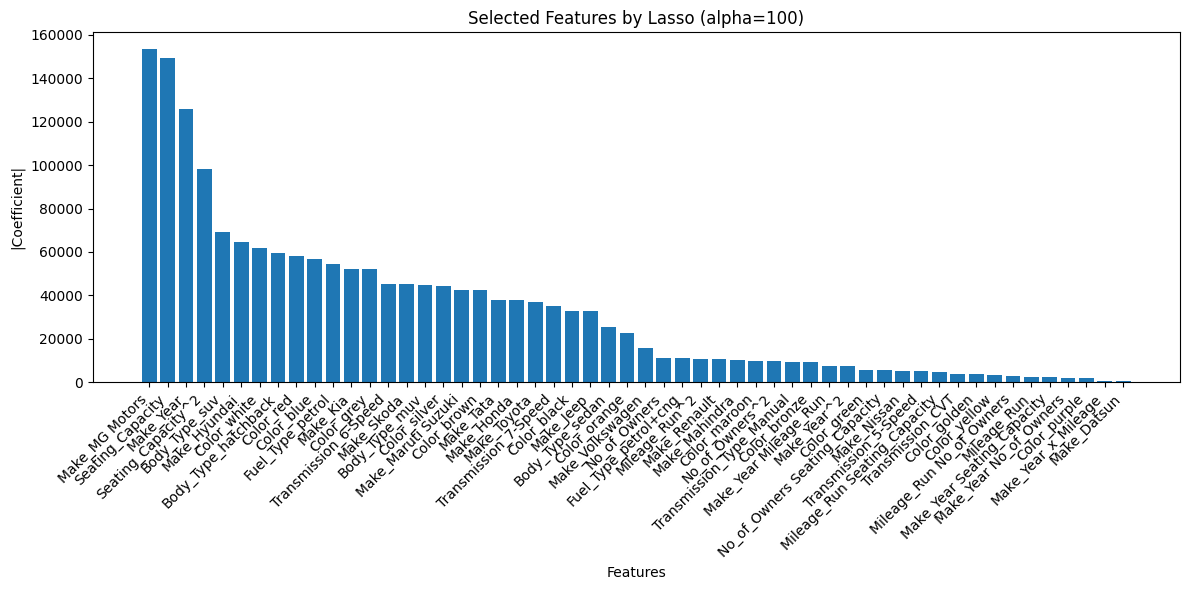


Model Comparison:
1. Simple Model:
Test RMSE: 143815.30
Test R²: 0.8197

2. Complex Model:
Test RMSE: 143025.91
Test R²: 0.8216

3. Best Lasso Model:
Test RMSE: 143015.63
Test R²: 0.8217


In [57]:
# PART 8
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

# standarize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_complex)
X_test_scaled = scaler.transform(X_test_complex)

# differnt alpha values
alphas = [0.1, 1, 10, 100]
results = []

for alpha in alphas:
    # fit model
    lasso = Lasso(alpha=alpha, random_state=42)
    lasso.fit(X_train_scaled, y_train_complex)
    
    # make predictions
    y_train_pred = lasso.predict(X_train_scaled)
    y_test_pred = lasso.predict(X_test_scaled)
    
    # calculate
    train_rmse = np.sqrt(mean_squared_error(y_train_complex, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test_complex, y_test_pred))
    train_r2 = r2_score(y_train_complex, y_train_pred)
    test_r2 = r2_score(y_test_complex, y_test_pred)
    
    # count nonzero coefficients
    n_features = np.sum(lasso.coef_ != 0)
    
    results.append({
        'alpha': alpha,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'n_features': n_features
    })

# determine best alpha
best_result = max(results, key=lambda x: x['test_r2'])
best_alpha = best_result['alpha']

# fit model with best alpha
best_lasso = Lasso(alpha=best_alpha, random_state=42)
best_lasso.fit(X_train_scaled, y_train_complex)

# get features
feature_importance = pd.DataFrame({
    'Feature': X_complex.columns,
    'Coefficient': best_lasso.coef_
})

# print features
print("\nSelected Features:")
selected_features = feature_importance[feature_importance['Coefficient'] != 0].sort_values(
    'Coefficient', key=abs, ascending=False
)
print(selected_features)

# visualize feature importance
plt.figure(figsize=(12, 6))
plt.bar(range(len(selected_features)), abs(selected_features['Coefficient']))
plt.xticks(range(len(selected_features)), selected_features['Feature'], rotation=45, ha='right')
plt.xlabel('Features')
plt.ylabel('|Coefficient|')
plt.title(f'Selected Features by Lasso (alpha={best_alpha})')
plt.tight_layout()
plt.show()

# compare with previous models
print("\nModel Comparison:")
print("1. Simple Model:")
print(f"Test RMSE: {full_metrics[2]:.2f}")
print(f"Test R²: {full_metrics[3]:.4f}")

print("\n2. Complex Model:")
print(f"Test RMSE: {test_rmse_complex:.2f}")
print(f"Test R²: {test_r2_complex:.4f}")

print("\n3. Best Lasso Model:")
print(f"Test RMSE: {best_result['test_rmse']:.2f}")
print(f"Test R²: {best_result['test_r2']:.4f}")